In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from pandas_plink import read_plink
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed
from sklearn import metrics
from math import sqrt
import lime
import lime.lime_tabular
from lime import submodular_pick
import random
from sklearn.metrics import roc_curve,roc_auc_score

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
(bim, fam, bed)=read_plink("/work/breastcancer/clean_test/train/sig0.001")
(bim2, fam2, bed2)=read_plink("/work/breastcancer/clean_test/validation/val0.001")
(bim3, fam3, bed3)=read_plink("/work/breastcancer/clean_test/test/test0.001")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


In [4]:
print(bim)


     chrom                       snp   cm        pos a0 a1     i
0        1                 rs4040605  0.0     856476  G  A     0
1        1          chr1_1914124_C_T  0.0    1914124  A  G     1
2        1          chr1_2501064_A_G  0.0    2501064  A  G     2
3        1          chr1_3410935_A_G  0.0    3410935  A  G     3
4        1          chr1_4515277_C_T  0.0    4515277  A  G     4
5        1          chr1_5178521_A_C  0.0    5178521  C  A     5
6        1                 rs2506889  0.0   10596022  A  G     6
7        1         chr1_10598216_A_G  0.0   10598216  A  G     7
8        1         chr1_10609973_G_T  0.0   10609973  A  C     8
9        1                 rs9430149  0.0   10612820  C  G     9
10       1                rs17035305  0.0   10616505  A  C    10
11       1         chr1_10617906_A_T  0.0   10617906  T  A    11
12       1                 rs4846235  0.0   10632235  A  G    12
13       1         chr1_10700448_C_T  0.0   10700448  G  A    13
14       1               

In [5]:
print(fam2)

                fid     iid father mother gender trait     i
0     BCAC-10004806  103990      0      0      2     2     0
1     BCAC-10014103  277737      0      0      2     1     1
2     BCAC-10031360  282353      0      0      2     1     2
3     BCAC-10058767  269188      0      0      2     1     3
4     BCAC-10061401  127256      0      0      2     2     4
5     BCAC-10065950  112568      0      0      2     1     5
6     BCAC-10066137   79981      0      0      2     2     6
7     BCAC-10094987  104959      0      0      2     1     7
8     BCAC-10110689  265234      0      0      2     2     8
9     BCAC-10118451  267854      0      0      2     1     9
10    BCAC-10122271  327261      0      0      2     1    10
11    BCAC-10158019  166687      0      0      2     2    11
12    BCAC-10179015  267308      0      0      2     1    12
13    BCAC-10182819  325984      0      0      2     1    13
14    BCAC-10214855   80201      0      0      2     2    14
15    BCAC-10220713  113

In [6]:
print("Convertion")
bed=bed.astype('uint8')
print("Compute")
X=bed.compute()
print("Filling Null Data")
X[np.isnan(X)]=2
#test
print("Convertion")
bed2=bed2.astype('uint8')
print("Compute")
X_val=bed2.compute()
print("Filling Null Data")
X_val[np.isnan(X_val)]=2

print("Convertion")
bed3=bed3.astype('uint8')
print("Compute")
X_test=bed3.compute()
print("Filling Null Data")
X_test[np.isnan(X_test)]=2

Convertion
Compute
Filling Null Data
Convertion
Compute
Filling Null Data
Convertion
Compute
Filling Null Data


In [7]:
print(X.shape)

(5273, 39289)


In [8]:
Y=fam["trait"].astype("int")
Y=Y-1
Xdf=pd.DataFrame(X.T)
Xdf["Y"]=Y
#Xdf=Xdf.sample(frac=1)

Y_val=fam2["trait"].astype("int")
Y_val=Y_val-1
Xdf_val=pd.DataFrame(X_val.T)
Xdf_val["Y"]=Y_val
#Xdf=Xdf.sample(frac=1)

Y_test=fam3["trait"].astype("int")
Y_test=Y_test-1
Xdf_test=pd.DataFrame(X_test.T)
Xdf_test["Y"]=Y_test
#Xdf=Xdf.sample(frac=1)

In [9]:
print(Xdf_val)

      0  1  2  3  4  5  6  7  8  9 ...  5264  5265  5266  5267  5268  5269  \
0     2  0  0  2  1  0  1  1  1  1 ...     0     1     2     2     2     1   
1     1  2  1  2  1  2  1  1  1  1 ...     1     0     0     2     2     0   
2     1  2  1  2  1  0  0  0  0  0 ...     2     1     1     2     2     2   
3     2  1  2  2  2  2  0  0  0  0 ...     0     1     1     0     0     2   
4     1  0  1  2  0  2  2  2  2  2 ...     2     1     1     1     1     1   
5     0  1  0  1  0  0  2  2  2  2 ...     2     0     0     2     2     1   
6     0  2  2  2  1  2  1  1  1  1 ...     2     2     2     1     2     1   
7     0  2  0  2  0  2  1  1  1  1 ...     1     0     0     1     1     1   
8     1  2  1  2  2  2  1  1  1  1 ...     2     1     1     1     1     1   
9     2  2  2  2  0  2  2  2  2  2 ...     2     1     1     1     1     1   
10    1  2  1  2  0  2  2  2  2  2 ...     2     2     2     1     1     1   
11    1  0  0  2  1  2  1  1  1  1 ...     2     1     1     2  

In [10]:
x_train=Xdf.drop(['Y'],axis=1).values
y_train=Xdf[['Y']].values

x_val=Xdf_val.drop(['Y'],axis=1).values
y_val=Xdf_val[['Y']].values

x_test=Xdf_test.drop(['Y'],axis=1).values
y_test=Xdf_test[['Y']].values

In [11]:
tf.reset_default_graph()
X=tf.placeholder(tf.float32,shape=(None,5273),name="X")
X_random=tf.placeholder(tf.float32,shape=(None,1),name="X")
Y=tf.placeholder(tf.float32,shape=(None,1),name="Y")

In [12]:

with tf.name_scope("dnn"):
    training = tf.placeholder_with_default(False, shape=(), name='training')
    initializer = tf.contrib.layers.xavier_initializer()
    hidden00_drop= tf.layers.dropout(X, 0.5, training=training)
    hidden01=tf.layers.dense(hidden00_drop, 1000, name="hidden01",activation=None, kernel_initializer=initializer)
    hidden01_norm=tf.layers.batch_normalization(hidden01, training=training, momentum=0.9)
    act_hidden01=tf.nn.leaky_relu(hidden01_norm)
    hidden01_drop = tf.layers.dropout(act_hidden01, 0.5, training=training)
    hidden0=tf.layers.dense(hidden01_drop, 250, name="hidden0",activation=None, kernel_initializer=initializer)
    hidden0_norm=tf.layers.batch_normalization(hidden0, training=training, momentum=0.9)
    act_hidden0=tf.nn.leaky_relu(hidden0_norm)
    hidden0_drop = tf.layers.dropout(act_hidden0, 0.5, training=training)
    hidden1=tf.layers.dense(hidden0_drop, 50, name="hidden1",activation=None, kernel_initializer=initializer)
    hidden1_norm=tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
    act_hidden1=tf.nn.leaky_relu(hidden1_norm)
    hidden1_drop = tf.layers.dropout(act_hidden1, 0.5, training=training)
    output=tf.layers.dense(  hidden1_drop, 1, name="output_final",activation=None)


W1212 10:04:17.383921 47345209260352 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1212 10:04:17.384743 47345209260352 deprecation.py:323] From <ipython-input-12-729f23675a53>:5: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W1212 10:04:17.545887 47345209260352 deprecation.py:323] From <ipython-input-12-729f23675a53>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1212 10:04:17.993321 47345209260352 deprecation.py:323] From <ipyt

In [13]:
with tf.name_scope("loss"):
    #l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.01, scope=None)
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=0.01, scope=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=output)
    weights = tf.trainable_variables()
    loss=tf.reduce_mean(cross_entropy)
    error=loss#+tf.contrib.layers.apply_regularization(l2_regularizer, weights)

W1212 10:04:18.365697 47345209260352 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
with tf.name_scope("train"):
    optimizer =tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name='Adam')
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(error)

In [15]:
with tf.name_scope("eval"):
    predicted = tf.nn.sigmoid(output)
    correct_pred = tf.equal(tf.round(predicted), Y)
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    _,auc = tf.metrics.auc(labels=Y,predictions=predicted)

W1212 10:04:19.187172 47345209260352 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py:809: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [224]:
sess.close()

In [16]:
saver=tf.train.Saver()


In [17]:
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count={ "CPU": 44}))


In [18]:
init=tf.global_variables_initializer()
loc=tf.local_variables_initializer()
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count={ "CPU": 44}))
init.run()
loc.run()
auc_tab=[]
accuracy_tab=[]
loss_tab=[]
epoch_tab=[]
auc_tab_val=[]
accuracy_tab_val=[]
loss_tab_val=[]
#wSNP=[[] for x in range(2000*2)]
#wSNPout=[[] for x in range(2)]

/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [229]:
sess.close()

In [20]:
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count={ "CPU": 44}))


In [21]:
saver.restore(sess, "/work/breastcancer/clean_test/logs/preprocessed001.ckpt")

W1212 10:04:21.665442 47345209260352 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [34]:
pred=sess.run(predicted,feed_dict={X:x_test,Y:y_test})

In [35]:
important=np.argwhere(pred==pred[pred>0.67])[:,0]

In [36]:
loc.run()
sess.run([loss,acc,auc],feed_dict={X:x_val,Y:y_val})

[0.6349695, 0.6095277, 0.6704849]

In [37]:
loc.run()
sess.run([loss,acc,auc],feed_dict={X:x_test,Y:y_test})

[0.63160145, 0.62235343, 0.6738763]

In [27]:
np.random.seed(1)

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train ,class_names=['not tumour', 'Tumor'],categorical_features = range(5273), feature_names = list(bim["snp"].values), kernel_width=40, verbose=True)

/opt/oscer/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
def predict_fn(x):
    if len(x.shape)>1:
         return np.array([1-sess.run(tf.nn.sigmoid(output),feed_dict={X:x})[:,0],sess.run(tf.nn.sigmoid(output),feed_dict={X:x})[:,0]]).T
    else:
        return np.array([[1-sess.run(tf.nn.sigmoid(output),feed_dict={X:np.expand_dims(x,axis=1).T})[0,0],sess.run(tf.nn.sigmoid(output),feed_dict={X:np.expand_dims(x,axis=1).T})[0,0]]])

In [38]:
sess.run(predicted,feed_dict={X:x_test,Y:y_test})

array([[0.4408413 ],
       [0.72026885],
       [0.6171559 ],
       ...,
       [0.53312004],
       [0.46355894],
       [0.65992373]], dtype=float32)

In [39]:
important.shape

(553,)

In [51]:
pick=submodular_pick.SubmodularPick(explainer, x_test[important], predict_fn, sample_size=553, num_features=1000, num_exps_desired=1)

Intercept 0.3751667264220283
Prediction_local [0.60281737]
Right: 0.6759864
Intercept 0.45633742564847607
Prediction_local [0.64401538]
Right: 0.68659985
Intercept 0.4163234853268111
Prediction_local [0.83756244]
Right: 0.9495586


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.203150992140917e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.34640264616911154
Prediction_local [0.68752693]
Right: 0.85689974
Intercept 0.49382261473141315
Prediction_local [0.70892854]
Right: 0.79888475


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2084210418215745e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5257438297636582
Prediction_local [0.65572417]
Right: 0.71817464


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.954565669212088e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4082615946836337
Prediction_local [0.74645014]
Right: 0.92125165
Intercept 0.5037412889783577
Prediction_local [0.65159719]
Right: 0.6972147


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.52130760710368e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4767645662790837
Prediction_local [0.59865074]
Right: 0.69610703
Intercept 0.47471639839343266
Prediction_local [0.61248229]
Right: 0.7082203


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7385348536338975e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5332578168173615
Prediction_local [0.74165288]
Right: 0.8790473


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.685915572123427e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38552247931597183
Prediction_local [0.75664417]
Right: 0.88268363
Intercept 0.4234421054211961
Prediction_local [0.74500483]
Right: 0.81601286


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.363251480611358e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42029749660719784
Prediction_local [0.63726762]
Right: 0.7040244


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0010925167836453e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3972014858189877
Prediction_local [0.78358058]
Right: 0.92903984
Intercept 0.5349183448594383
Prediction_local [0.8089301]
Right: 0.85397744
Intercept 0.31485266057884964
Prediction_local [0.7091731]
Right: 0.8276646


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.45008836140683e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4499776208277333
Prediction_local [0.76374599]
Right: 0.8772795
Intercept 0.3972428763586677
Prediction_local [0.66678426]
Right: 0.7126637


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.864063710565151e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5208588542225041
Prediction_local [0.78108378]
Right: 0.8230212


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.7481772718847664e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.34329753190582263
Prediction_local [0.71085923]
Right: 0.91580284
Intercept 0.3358645023954233
Prediction_local [0.82934109]
Right: 0.950099


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8246060290514577e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.44002408789861996
Prediction_local [0.71074183]
Right: 0.846956
Intercept 0.4555965956000976
Prediction_local [0.59799619]
Right: 0.6855926
Intercept 0.3851422387361859
Prediction_local [0.84225614]
Right: 0.9451405


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3786893504663583e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.421223996420448
Prediction_local [0.66623467]
Right: 0.7592738


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3901166237826582e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4876065638809668
Prediction_local [0.65911109]
Right: 0.7734486
Intercept 0.4204384684608232
Prediction_local [0.77179192]
Right: 0.86436176


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.3146737929863565e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4302197070629474
Prediction_local [0.60459535]
Right: 0.67374825
Intercept 0.4600789852421307
Prediction_local [0.67814033]
Right: 0.78401756
Intercept 0.38165913344072655
Prediction_local [0.65177096]
Right: 0.73299736
Intercept 0.45044916813527974
Prediction_local [0.65300026]
Right: 0.70376414


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6850620624661158e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3343020010058361
Prediction_local [0.74764907]
Right: 0.9422427
Intercept 0.47423952791645985
Prediction_local [0.63540471]
Right: 0.69747007
Intercept 0.3957873199446156
Prediction_local [0.76906412]
Right: 0.9262834
Intercept 0.37629395961270196
Prediction_local [0.81203696]
Right: 0.95593417
Intercept 0.30905329650548863
Prediction_local [0.75702708]
Right: 0.91304684
Intercept 0.44142710194521306
Prediction_local [0.74284528]
Right: 0.8727075


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.559262650192909e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.29603320527807525
Prediction_local [0.7387864]
Right: 0.8676115


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6464990423655297e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3957507587197337
Prediction_local [0.77320073]
Right: 0.9112849
Intercept 0.40839883378636216
Prediction_local [0.71673357]
Right: 0.81883276


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.917493781160379e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36603367773501105
Prediction_local [0.73573607]
Right: 0.86429346
Intercept 0.5013658284444817
Prediction_local [0.64557173]
Right: 0.711102


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.685560345852359e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43862713253007496
Prediction_local [0.68119814]
Right: 0.7804923


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.1886424875019614e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38950563923847326
Prediction_local [0.79296962]
Right: 0.93373764


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4591439500559666e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4106215119637381
Prediction_local [0.80435001]
Right: 0.9264669
Intercept 0.42433452735881505
Prediction_local [0.7325591]
Right: 0.8499174


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9813177774721663e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3788177814471135
Prediction_local [0.72081166]
Right: 0.8346158


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.544560420626484e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3892561410804815
Prediction_local [0.80067982]
Right: 0.9454346


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3086949861981878e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42542031005543607
Prediction_local [0.77143965]
Right: 0.92612636
Intercept 0.47920209474070014
Prediction_local [0.70953236]
Right: 0.8320203
Intercept 0.4145244385733418
Prediction_local [0.73056069]
Right: 0.8687587
Intercept 0.38105771250772996
Prediction_local [0.64767981]
Right: 0.74906987
Intercept 0.47343527337584557
Prediction_local [0.68473739]
Right: 0.72956645
Intercept 0.39921340814730166
Prediction_local [0.59397297]
Right: 0.67222786


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.213849530967953e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41087668377352615
Prediction_local [0.69257353]
Right: 0.80120856
Intercept 0.4244481661421607
Prediction_local [0.74542326]
Right: 0.8740401


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.724738070776523e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3643325894588498
Prediction_local [0.77164599]
Right: 0.9509443


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8281405814169076e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4638698986375026
Prediction_local [0.68772613]
Right: 0.7328628


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.881202746857008e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.47236104454591105
Prediction_local [0.74704105]
Right: 0.8236004
Intercept 0.2947587397798036
Prediction_local [0.76664307]
Right: 0.86679727


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.8997228056334325e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4600444086416393
Prediction_local [0.86236906]
Right: 0.95825016
Intercept 0.4062928072698565
Prediction_local [0.78618885]
Right: 0.9391781


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7057837025568845e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4655791422191845
Prediction_local [0.84810511]
Right: 0.9686072
Intercept 0.488891174887815
Prediction_local [0.84412537]
Right: 0.968041
Intercept 0.3344215794030703
Prediction_local [0.64018932]
Right: 0.7020353


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.562823559557001e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45080179075611027
Prediction_local [0.67047619]
Right: 0.79780126
Intercept 0.527120278751234
Prediction_local [0.71871435]
Right: 0.81946087
Intercept 0.35104071213732124
Prediction_local [0.7431862]
Right: 0.8819598


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.895874144608805e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4924278785623632
Prediction_local [0.74758389]
Right: 0.92371106


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.567320220682809e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5183385978987669
Prediction_local [0.78159163]
Right: 0.91054124


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5845979194747586e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.48134598706222675
Prediction_local [0.64834956]
Right: 0.6806317
Intercept 0.4237611504113872
Prediction_local [0.64409551]
Right: 0.6922209


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.471541923381024e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4123056998730663
Prediction_local [0.65854366]
Right: 0.7120685
Intercept 0.4840699587415975
Prediction_local [0.64782549]
Right: 0.71984553


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2220544473198043e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4576763289701734
Prediction_local [0.62967934]
Right: 0.69840604


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.060769227539654e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.436138537173122
Prediction_local [0.67396748]
Right: 0.74628913
Intercept 0.4093745512437089
Prediction_local [0.73878558]
Right: 0.8809114


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.989447270601134e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4929850205092424
Prediction_local [0.60658079]
Right: 0.68795395
Intercept 0.3802467717470032
Prediction_local [0.7911476]
Right: 0.8607195
Intercept 0.38064666213003506
Prediction_local [0.64575107]
Right: 0.68059576
Intercept 0.35333258443713933
Prediction_local [0.83400118]
Right: 0.94453466
Intercept 0.2879378862856196
Prediction_local [0.75469258]
Right: 0.87163794


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.501631776356015e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3688975986748675
Prediction_local [0.68032397]
Right: 0.7718002
Intercept 0.42413508425056795
Prediction_local [0.76579695]
Right: 0.9228115


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.17167382360798e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39431834178209374
Prediction_local [0.63145464]
Right: 0.68485075
Intercept 0.3405381683706615
Prediction_local [0.75799452]
Right: 0.9269945
Intercept 0.4227019400530281
Prediction_local [0.74717584]
Right: 0.76095515
Intercept 0.3731322097793129
Prediction_local [0.73611134]
Right: 0.8992983


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0681576271134177e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43952905746610066
Prediction_local [0.75824551]
Right: 0.8724738


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.503552706196011e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3023717164387385
Prediction_local [0.79603216]
Right: 0.961789
Intercept 0.46989576210244
Prediction_local [0.65334824]
Right: 0.6995997
Intercept 0.3226079634203579
Prediction_local [0.79301944]
Right: 0.95150644


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.544080054159368e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3580203077757757
Prediction_local [0.7313276]
Right: 0.8777751


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4575553793193323e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4068518438721692
Prediction_local [0.62320474]
Right: 0.6909207


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8063508904453995e-21 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3918824669593602
Prediction_local [0.69113922]
Right: 0.7302635
Intercept 0.42314208881164894
Prediction_local [0.71098425]
Right: 0.79331815


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.94860458467071e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4892607804654248
Prediction_local [0.66767966]
Right: 0.71419364


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.722190199700773e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37055276732031633
Prediction_local [0.84123647]
Right: 0.9563651


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.4945332336973156e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3982917770964417
Prediction_local [0.70708033]
Right: 0.77753687
Intercept 0.40613639966420534
Prediction_local [0.79293432]
Right: 0.95991796


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1959467387789908e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4378842243147456
Prediction_local [0.68039316]
Right: 0.7590134


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.673263585676138e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36923574076886273
Prediction_local [0.70348266]
Right: 0.8316779


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6971372060236704e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5412252214959496
Prediction_local [0.58301526]
Right: 0.69040525


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2133165639642115e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40654248787132274
Prediction_local [0.61411144]
Right: 0.71462744
Intercept 0.42837917593179103
Prediction_local [0.67948632]
Right: 0.7140168
Intercept 0.30513686185595024
Prediction_local [0.79467621]
Right: 0.9610991


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.028697102829269e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3949469818977514
Prediction_local [0.72185594]
Right: 0.8163229
Intercept 0.3590913545986528
Prediction_local [0.84779731]
Right: 0.96705973


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.845956704818397e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5030273418678886
Prediction_local [0.65728918]
Right: 0.68318194


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0969884043743777e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39642103221740443
Prediction_local [0.73314543]
Right: 0.8715252


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.59723338632827e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35328648554534636
Prediction_local [0.86006742]
Right: 0.93798417


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.655343281635156e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.493095989174472
Prediction_local [0.60356852]
Right: 0.6762559
Intercept 0.3953967460421036
Prediction_local [0.82420245]
Right: 0.97689986


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.936844337934095e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4031295065091859
Prediction_local [0.74159511]
Right: 0.88565606


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2495061374044202e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4629912558934851
Prediction_local [0.62211567]
Right: 0.6745349


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.493748020458165e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40895603062720004
Prediction_local [0.74885667]
Right: 0.9149003


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.581938676063469e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3636690570537898
Prediction_local [0.76070037]
Right: 0.8897607
Intercept 0.4455234225458381
Prediction_local [0.87669231]
Right: 0.974059
Intercept 0.3848635467956613
Prediction_local [0.69511586]
Right: 0.8005549


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.12908499986453e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38922109473529765
Prediction_local [0.70465905]
Right: 0.77248985
Intercept 0.37333953255874336
Prediction_local [0.81570482]
Right: 0.95666754
Intercept 0.4280424499183929
Prediction_local [0.66770347]
Right: 0.81237936
Intercept 0.47081065997682076
Prediction_local [0.62383083]
Right: 0.6953294
Intercept 0.3621132611285809
Prediction_local [0.71858475]
Right: 0.8638532


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5139340183052135e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37023248711392065
Prediction_local [0.74770348]
Right: 0.9565108


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.28257720945392e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.32902995057500245
Prediction_local [0.68330923]
Right: 0.8189218
Intercept 0.5120734725887855
Prediction_local [0.62418339]
Right: 0.6864512
Intercept 0.2969712178392381
Prediction_local [0.61113416]
Right: 0.74245155


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.583515609076518e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3605723456890674
Prediction_local [0.81667845]
Right: 0.9689338
Intercept 0.37522052840553327
Prediction_local [0.85578834]
Right: 0.96328884
Intercept 0.4309076005956767
Prediction_local [0.71893259]
Right: 0.8633014


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2494723424437206e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.29065543603868393
Prediction_local [0.78382646]
Right: 0.8983933
Intercept 0.3883565423082741
Prediction_local [0.62926793]
Right: 0.6856207
Intercept 0.41769725050514095
Prediction_local [0.64954527]
Right: 0.71552163
Intercept 0.40990515300546804
Prediction_local [0.80928907]
Right: 0.94302076


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.139586219283683e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4761709003936909
Prediction_local [0.63608255]
Right: 0.71435344
Intercept 0.37886568690857947
Prediction_local [0.65477326]
Right: 0.72725976


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.180430118758431e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.49195458087472316
Prediction_local [0.82474614]
Right: 0.88098705
Intercept 0.39280844500157336
Prediction_local [0.77752198]
Right: 0.8890914


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4428683184215392e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4798096467536372
Prediction_local [0.83957772]
Right: 0.9022457
Intercept 0.41375664764746406
Prediction_local [0.65835324]
Right: 0.7532146
Intercept 0.42293340635793353
Prediction_local [0.71853142]
Right: 0.8516237


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3355585909611674e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4034755582474579
Prediction_local [0.6490418]
Right: 0.7431129
Intercept 0.5048796379027098
Prediction_local [0.6740786]
Right: 0.74891925
Intercept 0.4348133030373824
Prediction_local [0.80202283]
Right: 0.8906739


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3975450222510812e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38969826070868824
Prediction_local [0.76089797]
Right: 0.8776195
Intercept 0.39588006634025424
Prediction_local [0.7303856]
Right: 0.83320695


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.565813187589478e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.461047085293882
Prediction_local [0.65635555]
Right: 0.6879386


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.320163789804406e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4838460495000907
Prediction_local [0.63801303]
Right: 0.74418294
Intercept 0.444481887983203
Prediction_local [0.69091996]
Right: 0.73557407


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.910575586583223e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4432603071159922
Prediction_local [0.65616343]
Right: 0.76179653


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.9754204155537875e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3898908931750113
Prediction_local [0.59785623]
Right: 0.713475
Intercept 0.4893953794549707
Prediction_local [0.71258597]
Right: 0.82844114
Intercept 0.4610112158112279
Prediction_local [0.6658083]
Right: 0.73017406


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.85568476211448e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.28106741528596113
Prediction_local [0.75761644]
Right: 0.9165344
Intercept 0.396377283986466
Prediction_local [0.60242677]
Right: 0.6751082
Intercept 0.32742739272317906
Prediction_local [0.7278086]
Right: 0.86112875


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.991167924382178e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4148486603899921
Prediction_local [0.7100542]
Right: 0.83943534


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9402162012223828e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3810763579466363
Prediction_local [0.69769461]
Right: 0.8182725


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7502884883688785e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42791296561055164
Prediction_local [0.67238057]
Right: 0.71628046
Intercept 0.42681314221307826
Prediction_local [0.76054521]
Right: 0.8636066


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4788060641670497e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45355860907249845
Prediction_local [0.63591346]
Right: 0.6851999
Intercept 0.43354378835325325
Prediction_local [0.70920753]
Right: 0.8116332


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.651610879250776e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4746180833177927
Prediction_local [0.66286786]
Right: 0.729416


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.424901209917752e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45864802390308435
Prediction_local [0.83260857]
Right: 0.9039891
Intercept 0.30269527208141866
Prediction_local [0.80621296]
Right: 0.9432734
Intercept 0.44236785618086094
Prediction_local [0.70965918]
Right: 0.8506558


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.56229448590215e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40868348518197706
Prediction_local [0.70813264]
Right: 0.8567356


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4947786501323167e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35155215951145025
Prediction_local [0.74481914]
Right: 0.89305913


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.530618675732496e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3161909231851723
Prediction_local [0.78368866]
Right: 0.96095747
Intercept 0.40241930028725525
Prediction_local [0.73912998]
Right: 0.8962201
Intercept 0.356710313135573
Prediction_local [0.82853017]
Right: 0.9428854


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.009681568885953e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3622053489763962
Prediction_local [0.72724045]
Right: 0.8791255
Intercept 0.35574725455416184
Prediction_local [0.66037546]
Right: 0.7732771
Intercept 0.5623515763502659
Prediction_local [0.62971636]
Right: 0.6811245


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.223515971372197e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4749375234532281
Prediction_local [0.77159457]
Right: 0.90115297
Intercept 0.368577385557443
Prediction_local [0.7642949]
Right: 0.9167622
Intercept 0.3841516148571942
Prediction_local [0.78784582]
Right: 0.9417889
Intercept 0.4154630727953567
Prediction_local [0.64391324]
Right: 0.7614682


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.1431719697898533e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3397057400178991
Prediction_local [0.74929662]
Right: 0.8627173
Intercept 0.39381402348759603
Prediction_local [0.81372507]
Right: 0.91652596
Intercept 0.3903034307815793
Prediction_local [0.69113332]
Right: 0.80514115
Intercept 0.41603215433217716
Prediction_local [0.74115366]
Right: 0.87306887
Intercept 0.41764190981922045
Prediction_local [0.69540712]
Right: 0.73526883
Intercept 0.426094675463627
Prediction_local [0.72187681]
Right: 0.8689044
Intercept 0.4195255956083562
Prediction_local [0.75773017]
Right: 0.9458077


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5436117300163003e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39656367178624613
Prediction_local [0.7662698]
Right: 0.877445


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.8857773356561925e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4091992357849618
Prediction_local [0.7371264]
Right: 0.8687756


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5926048474082017e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.44185452093497857
Prediction_local [0.73981183]
Right: 0.83898795


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.39692034601553e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42821842574569335
Prediction_local [0.66552682]
Right: 0.73175037
Intercept 0.41186900298908474
Prediction_local [0.65086631]
Right: 0.70618707


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.907298086196373e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3676572041006364
Prediction_local [0.82249574]
Right: 0.9676565


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.383830035462236e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4237756188638636
Prediction_local [0.84344258]
Right: 0.9327612


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.247506065096103e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37994443013911017
Prediction_local [0.65859322]
Right: 0.6748628
Intercept 0.5021084167024924
Prediction_local [0.60919769]
Right: 0.68727887


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6382479738288427e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4185619997673
Prediction_local [0.77390972]
Right: 0.8980855


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.1566640343043824e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4520268886501445
Prediction_local [0.81464176]
Right: 0.8884158
Intercept 0.31380266429986703
Prediction_local [0.65435495]
Right: 0.7635689


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.05722465077574e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.32066603753081463
Prediction_local [0.70434915]
Right: 0.8041092


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.739373999428414e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4925551298497828
Prediction_local [0.74627334]
Right: 0.7875956


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.766645897880465e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3491587670517603
Prediction_local [0.71081161]
Right: 0.85003006


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3393830074095998e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3726890551048606
Prediction_local [0.77515594]
Right: 0.9010866


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.50056604839531e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4196751611218384
Prediction_local [0.64904161]
Right: 0.7460844


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.63106623013027e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.49337511928700856
Prediction_local [0.68574573]
Right: 0.83273196
Intercept 0.38937363779829826
Prediction_local [0.64354054]
Right: 0.7167233


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.9080184285464075e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3857443438138818
Prediction_local [0.74659932]
Right: 0.8921689
Intercept 0.4523953603825673
Prediction_local [0.62724812]
Right: 0.71785605


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2732128316713226e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43661920880472777
Prediction_local [0.73576288]
Right: 0.91594243


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.351455912909109e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3533489098631061
Prediction_local [0.68789851]
Right: 0.822192
Intercept 0.5278448655381894
Prediction_local [0.64697116]
Right: 0.73855096
Intercept 0.3385974202166201
Prediction_local [0.8467691]
Right: 0.9359348
Intercept 0.43513351614649065
Prediction_local [0.63866902]
Right: 0.6953005
Intercept 0.30186808533544524
Prediction_local [0.72460409]
Right: 0.86695904


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6888089319586552e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4872603730213602
Prediction_local [0.70401915]
Right: 0.80320895


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.549995238576047e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4403791329250355
Prediction_local [0.64329261]
Right: 0.8227142
Intercept 0.49310164983705723
Prediction_local [0.69883481]
Right: 0.7902866


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4056041745328207e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.404868410899913
Prediction_local [0.78476511]
Right: 0.9497439


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.726124343056446e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.2879545193514731
Prediction_local [0.80086487]
Right: 0.9122843
Intercept 0.4657766469457109
Prediction_local [0.65729853]
Right: 0.7001506


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.899341185854902e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5403406668091486
Prediction_local [0.75613497]
Right: 0.88356364
Intercept 0.33360656156368973
Prediction_local [0.7351096]
Right: 0.8775649


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.564943291515637e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39666002998024047
Prediction_local [0.68139637]
Right: 0.7274065
Intercept 0.4336551421988889
Prediction_local [0.67322217]
Right: 0.8508234
Intercept 0.36282885282348204
Prediction_local [0.67372506]
Right: 0.8126896


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.09180667505143e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3990625530487271
Prediction_local [0.70950596]
Right: 0.76578295


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8370398647166376e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.375148780318047
Prediction_local [0.72242202]
Right: 0.84422016


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7671388546461277e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4801216275953746
Prediction_local [0.74409328]
Right: 0.8060205


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3280535551457322e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4634971989387959
Prediction_local [0.83919315]
Right: 0.9510883


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.4903955021861866e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45039079966396073
Prediction_local [0.83098517]
Right: 0.9143852
Intercept 0.4693600780768867
Prediction_local [0.79269228]
Right: 0.94185424
Intercept 0.35767437244471856
Prediction_local [0.70061043]
Right: 0.81608653
Intercept 0.321400359606197
Prediction_local [0.81443945]
Right: 0.9321596
Intercept 0.5020131959543239
Prediction_local [0.65526699]
Right: 0.7212171


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.785476388924977e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42247541560977037
Prediction_local [0.75282119]
Right: 0.9438901


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.097549186144889e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41985444425723206
Prediction_local [0.65502337]
Right: 0.7462665


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.115274029103019e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.31169376959599027
Prediction_local [0.80856558]
Right: 0.92936885
Intercept 0.37134498114638215
Prediction_local [0.75158449]
Right: 0.8380889
Intercept 0.44500594060057547
Prediction_local [0.78686927]
Right: 0.88237464


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.1234629207760475e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42328630283142527
Prediction_local [0.80965839]
Right: 0.8526678
Intercept 0.5303349459576915
Prediction_local [0.83815687]
Right: 0.87942386
Intercept 0.37885047719397774
Prediction_local [0.7977248]
Right: 0.9291029


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.724151470479753e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3464758795630754
Prediction_local [0.7722998]
Right: 0.9317032
Intercept 0.39310130653973346
Prediction_local [0.7188523]
Right: 0.7804781
Intercept 0.3768158118008308
Prediction_local [0.68379858]
Right: 0.76143986
Intercept 0.37683993298815865
Prediction_local [0.70650535]
Right: 0.86714387


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.638187061625665e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41529430080198376
Prediction_local [0.67752513]
Right: 0.79159975


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5539662247356584e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5194158034776452
Prediction_local [0.70113028]
Right: 0.7877493
Intercept 0.42673576972962995
Prediction_local [0.61175163]
Right: 0.6701759


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.849698417174273e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4697302838343917
Prediction_local [0.69116597]
Right: 0.78780025


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.3140816867834335e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35688399538839066
Prediction_local [0.81900532]
Right: 0.91829026


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.253818761229781e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3960359626704184
Prediction_local [0.60917529]
Right: 0.678529


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.715163885876885e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4112847886897102
Prediction_local [0.82162745]
Right: 0.9644196


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.9893537596834305e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3589316301437591
Prediction_local [0.77467114]
Right: 0.8887195
Intercept 0.4079597461293253
Prediction_local [0.6214663]
Right: 0.686641
Intercept 0.4491635155975643
Prediction_local [0.67870922]
Right: 0.83287054
Intercept 0.27997006708745487
Prediction_local [0.70377029]
Right: 0.90654784


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.49571633458193e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5372727928103098
Prediction_local [0.64005252]
Right: 0.7279607


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.939722018504885e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.480016413199199
Prediction_local [0.6529435]
Right: 0.6882514
Intercept 0.43966663527305605
Prediction_local [0.70079371]
Right: 0.84120154
Intercept 0.46880817664244206
Prediction_local [0.67154984]
Right: 0.7693382
Intercept 0.38421374949270304
Prediction_local [0.79595494]
Right: 0.89234936


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.516543830890153e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.48979770642276066
Prediction_local [0.63723546]
Right: 0.71484846


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.755416004380482e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37489290731735014
Prediction_local [0.81965678]
Right: 0.9464942
Intercept 0.36090389927744926
Prediction_local [0.64714463]
Right: 0.7019573
Intercept 0.4297048535197166
Prediction_local [0.63898832]
Right: 0.7113232
Intercept 0.3978338754978343
Prediction_local [0.62096091]
Right: 0.6722193
Intercept 0.37930585993473787
Prediction_local [0.79114293]
Right: 0.9090004


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6737932612351113e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41470671219428756
Prediction_local [0.70834583]
Right: 0.8096003


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4439801345854717e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39542865634031815
Prediction_local [0.71874363]
Right: 0.8617891


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.904483142315218e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4310986651683906
Prediction_local [0.8042717]
Right: 0.9619663
Intercept 0.38235914606035726
Prediction_local [0.72922971]
Right: 0.84959835


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8295073066280837e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42923734612814834
Prediction_local [0.63072396]
Right: 0.70361626


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.774927969025518e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4123854226667554
Prediction_local [0.60861398]
Right: 0.7127217
Intercept 0.4171247689503964
Prediction_local [0.82079522]
Right: 0.9270092
Intercept 0.5606389782409037
Prediction_local [0.87103177]
Right: 0.92768514
Intercept 0.4320381635706758
Prediction_local [0.79910206]
Right: 0.8936504
Intercept 0.47629093219664614
Prediction_local [0.62698068]
Right: 0.6887466
Intercept 0.4191590394366421
Prediction_local [0.6966167]
Right: 0.854829


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.379261955428205e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45726276006991884
Prediction_local [0.71234013]
Right: 0.81766784
Intercept 0.44738286184379
Prediction_local [0.73603275]
Right: 0.8865042
Intercept 0.42510721041873045
Prediction_local [0.71927362]
Right: 0.9012687


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.115715030562883e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38217529865696387
Prediction_local [0.7314383]
Right: 0.76838875
Intercept 0.4606849630425216
Prediction_local [0.60553608]
Right: 0.6741184
Intercept 0.44435593134538154
Prediction_local [0.72406323]
Right: 0.8146101


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.788480866246889e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41833556625940965
Prediction_local [0.74730911]
Right: 0.8600356


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2520644572280243e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.48263782818808443
Prediction_local [0.66016026]
Right: 0.77380836
Intercept 0.48861824919150765
Prediction_local [0.67993286]
Right: 0.7314109
Intercept 0.46551794139560493
Prediction_local [0.63724153]
Right: 0.70512533


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.649232288649949e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3800283265396531
Prediction_local [0.79390732]
Right: 0.8958092
Intercept 0.46469979033774306
Prediction_local [0.69979882]
Right: 0.8558318
Intercept 0.3899673637872548
Prediction_local [0.64913575]
Right: 0.69173837
Intercept 0.4287436174913348
Prediction_local [0.76069546]
Right: 0.8748776


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.6402827023655706e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.47010026880751216
Prediction_local [0.64201942]
Right: 0.6847299


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.50716437737209e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3981809132960235
Prediction_local [0.71172305]
Right: 0.7765447
Intercept 0.3247152578362004
Prediction_local [0.73830866]
Right: 0.84355295


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5059114368264317e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4407861729303089
Prediction_local [0.80159706]
Right: 0.94830614


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3893137156927935e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43468167282470793
Prediction_local [0.83198921]
Right: 0.891724


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1628065909384761e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.34046820376468356
Prediction_local [0.83008501]
Right: 0.95737445
Intercept 0.501256665068561
Prediction_local [0.79928632]
Right: 0.92638147


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.038899059995517e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40795030464327375
Prediction_local [0.78797096]
Right: 0.93077207
Intercept 0.5469967492390195
Prediction_local [0.65810781]
Right: 0.7274976
Intercept 0.41251418583216504
Prediction_local [0.72021573]
Right: 0.8180448
Intercept 0.4282143456939123
Prediction_local [0.77663936]
Right: 0.9086502
Intercept 0.41652438110726847
Prediction_local [0.69014219]
Right: 0.7738154
Intercept 0.3878767898334471
Prediction_local [0.63148468]
Right: 0.7274586


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5420317824011662e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4933467815232686
Prediction_local [0.65198705]
Right: 0.7236248
Intercept 0.37146979426193993
Prediction_local [0.62194263]
Right: 0.68185174
Intercept 0.44295864223445824
Prediction_local [0.74286102]
Right: 0.8835877


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.070521813296119e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3758090640838193
Prediction_local [0.77163222]
Right: 0.83059275
Intercept 0.38372566934902996
Prediction_local [0.6922502]
Right: 0.8044712
Intercept 0.3564627056615557
Prediction_local [0.73647424]
Right: 0.8827554


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.793390250252685e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41906353912647987
Prediction_local [0.82879666]
Right: 0.9667467


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5705730678886925e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5258400488263785
Prediction_local [0.61106179]
Right: 0.6911865


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7957853419760663e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45004987816025227
Prediction_local [0.75963633]
Right: 0.82586104
Intercept 0.3911209543490203
Prediction_local [0.594383]
Right: 0.6974691
Intercept 0.4122727154647378
Prediction_local [0.72304851]
Right: 0.8568963
Intercept 0.34969931398181553
Prediction_local [0.6077243]
Right: 0.6719205


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.05707236497496e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5188335542899893
Prediction_local [0.73688577]
Right: 0.8211688
Intercept 0.40686675047125415
Prediction_local [0.79791305]
Right: 0.9438771


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0833066812659196e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3621258218811687
Prediction_local [0.7445216]
Right: 0.9092363


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5105156119974755e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4255620756064281
Prediction_local [0.67890546]
Right: 0.8544412
Intercept 0.47364303488885234
Prediction_local [0.82623861]
Right: 0.94562685
Intercept 0.5042053776849856
Prediction_local [0.84540966]
Right: 0.8955499
Intercept 0.4455512792549944
Prediction_local [0.61711386]
Right: 0.67449504
Intercept 0.4176756224543049
Prediction_local [0.63625772]
Right: 0.6706826


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.648854640984507e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4384816497156183
Prediction_local [0.63957822]
Right: 0.75413984


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4461115839655157e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3830644817824331
Prediction_local [0.71525942]
Right: 0.7426627


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.137410542868381e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4464043291118064
Prediction_local [0.63025387]
Right: 0.7130242
Intercept 0.42067706464802934
Prediction_local [0.72948003]
Right: 0.881668
Intercept 0.3616858465555932
Prediction_local [0.7375436]
Right: 0.92087567
Intercept 0.3735050440891137
Prediction_local [0.72124797]
Right: 0.893463
Intercept 0.463911675354496
Prediction_local [0.59314242]
Right: 0.6720629


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0969369383561014e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4393229520127353
Prediction_local [0.62553335]
Right: 0.70371735


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.090674555719665e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5009060897657599
Prediction_local [0.67314113]
Right: 0.7441152


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.402287933149729e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5265107153713947
Prediction_local [0.63862177]
Right: 0.68857753
Intercept 0.29034936040877124
Prediction_local [0.70875599]
Right: 0.8296732


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6223489044379621e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3823454206118076
Prediction_local [0.71006594]
Right: 0.87676203
Intercept 0.4100991121051816
Prediction_local [0.61931253]
Right: 0.6888006


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.25916418494062e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3978851435826389
Prediction_local [0.66493937]
Right: 0.770096


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0534887248091895e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.39903286698472684
Prediction_local [0.6592348]
Right: 0.7398678


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4080249497994807e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3852816839739784
Prediction_local [0.73320632]
Right: 0.89298564
Intercept 0.47534225198031976
Prediction_local [0.6782568]
Right: 0.68773526


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.90431493175161e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5119485040693488
Prediction_local [0.65959029]
Right: 0.7045194


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.878646016254769e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4404416640191271
Prediction_local [0.60394256]
Right: 0.7031429


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.723103399869392e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.49931581639956324
Prediction_local [0.7302771]
Right: 0.8300692


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.18701960227524e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45844249582707974
Prediction_local [0.63150066]
Right: 0.7050262


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.751076004284536e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.28110806902944263
Prediction_local [0.81563668]
Right: 0.94798255


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7967277507937587e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4200538100198364
Prediction_local [0.79786883]
Right: 0.91832054
Intercept 0.3984384396244529
Prediction_local [0.73728512]
Right: 0.9087082


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.963027337219178e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37044646616791127
Prediction_local [0.80696068]
Right: 0.9427332


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0618007117943958e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36319131200116406
Prediction_local [0.69294868]
Right: 0.7919481
Intercept 0.40101586905265485
Prediction_local [0.81826968]
Right: 0.9106995
Intercept 0.4154408814233881
Prediction_local [0.62063772]
Right: 0.6907301


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2174302718605643e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4109408638011483
Prediction_local [0.79872422]
Right: 0.9299545
Intercept 0.36158564286248424
Prediction_local [0.67516412]
Right: 0.74872684
Intercept 0.4644169882007314
Prediction_local [0.70414444]
Right: 0.73299754


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2357100772952844e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.30734996867664377
Prediction_local [0.75466726]
Right: 0.91432166


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4460995196006894e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40334891189297006
Prediction_local [0.76078703]
Right: 0.90188843
Intercept 0.43312079757319494
Prediction_local [0.78145518]
Right: 0.83617


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.06551106871722e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3729203226212139
Prediction_local [0.8083719]
Right: 0.8883959
Intercept 0.380402793764356
Prediction_local [0.72139409]
Right: 0.80065423


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7209440336994084e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38193802735798876
Prediction_local [0.67291479]
Right: 0.74243337


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6143138263212736e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4055372511447642
Prediction_local [0.81080069]
Right: 0.952899
Intercept 0.42404607850886367
Prediction_local [0.69913024]
Right: 0.8183204


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.220577376358169e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41522690304763804
Prediction_local [0.70092572]
Right: 0.8199395
Intercept 0.42808744840792584
Prediction_local [0.76415366]
Right: 0.8909105
Intercept 0.4862035273669468
Prediction_local [0.6524062]
Right: 0.7611865
Intercept 0.3504716065286132
Prediction_local [0.67368846]
Right: 0.7454753
Intercept 0.4160190706563675
Prediction_local [0.60990936]
Right: 0.67164826
Intercept 0.4229822894266043
Prediction_local [0.71338162]
Right: 0.8561388
Intercept 0.2551574759301762
Prediction_local [0.74600898]
Right: 0.90179753


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0134694706035465e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3786591724671237
Prediction_local [0.63577593]
Right: 0.70485616


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6087507739849635e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3843270949654699
Prediction_local [0.72416215]
Right: 0.83405036
Intercept 0.4220251186584226
Prediction_local [0.73345514]
Right: 0.89495677
Intercept 0.43028113906601123
Prediction_local [0.668537]
Right: 0.7566735
Intercept 0.4314825884179893
Prediction_local [0.76041496]
Right: 0.7998508


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2211506221490084e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36892377568844636
Prediction_local [0.81035878]
Right: 0.9664432
Intercept 0.36863514397609565
Prediction_local [0.70397234]
Right: 0.75126636


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.2695967004437315e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3822830565987234
Prediction_local [0.8283327]
Right: 0.9713739
Intercept 0.3972428278891714
Prediction_local [0.72109632]
Right: 0.848595
Intercept 0.5298320033466737
Prediction_local [0.62341386]
Right: 0.67092836


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.705231313138713e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.395696720007293
Prediction_local [0.67576509]
Right: 0.7443326


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6706668424127884e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5149429982614887
Prediction_local [0.64795498]
Right: 0.6901581


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5349702083126988e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.44563691992196963
Prediction_local [0.79710089]
Right: 0.8957199
Intercept 0.3986311779807407
Prediction_local [0.6703523]
Right: 0.7450552


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0734824447321685e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4842092633468041
Prediction_local [0.62851411]
Right: 0.7082502
Intercept 0.3632368728887829
Prediction_local [0.62747868]
Right: 0.71524256
Intercept 0.33273264199031305
Prediction_local [0.77072132]
Right: 0.9088732


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.124111917133551e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4170241640971736
Prediction_local [0.6911599]
Right: 0.8103899


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.1347176443851755e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3780393042983638
Prediction_local [0.64543322]
Right: 0.71791506


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1861527050207848e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3519580986811165
Prediction_local [0.78030707]
Right: 0.90964043


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.188898533342817e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36960597672146656
Prediction_local [0.83800558]
Right: 0.9561403


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6398265824632438e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37150394798906744
Prediction_local [0.87001377]
Right: 0.96829915


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.695188376794329e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4624000183258407
Prediction_local [0.64249673]
Right: 0.72026885
Intercept 0.4113411976888814
Prediction_local [0.83147743]
Right: 0.9530263
Intercept 0.39871141761790724
Prediction_local [0.6422647]
Right: 0.73387575
Intercept 0.44341702594278165
Prediction_local [0.66353848]
Right: 0.76708674
Intercept 0.45580424225114424
Prediction_local [0.70399345]
Right: 0.83000195


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.308932750460871e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4541883415461316
Prediction_local [0.64326477]
Right: 0.6761895


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4802217797726944e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35464716455419454
Prediction_local [0.7568628]
Right: 0.91101134
Intercept 0.3153114493138961
Prediction_local [0.82248373]
Right: 0.9390935
Intercept 0.5095036341194287
Prediction_local [0.73281569]
Right: 0.76082414
Intercept 0.3939945189286501
Prediction_local [0.74249776]
Right: 0.8329718


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.273975739853272e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4174595962320522
Prediction_local [0.64136342]
Right: 0.69645953
Intercept 0.338776495599018
Prediction_local [0.80360743]
Right: 0.9544855


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6670152591769406e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3515312921723053
Prediction_local [0.6152533]
Right: 0.6709939
Intercept 0.42184570592214526
Prediction_local [0.75085151]
Right: 0.85718215
Intercept 0.47208895573470494
Prediction_local [0.63626047]
Right: 0.6987338
Intercept 0.5156346159764017
Prediction_local [0.67016667]
Right: 0.7961093
Intercept 0.3488107830958948
Prediction_local [0.73500834]
Right: 0.947268
Intercept 0.41659286448629373
Prediction_local [0.72789789]
Right: 0.89142513


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.143166184760564e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38025935462001853
Prediction_local [0.70598539]
Right: 0.88243043


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.934178297785363e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42817655768269497
Prediction_local [0.77015094]
Right: 0.9029237
Intercept 0.4197495203135744
Prediction_local [0.79581229]
Right: 0.9197855
Intercept 0.36331240632185385
Prediction_local [0.75886577]
Right: 0.868176
Intercept 0.4772666357162792
Prediction_local [0.71819153]
Right: 0.88186836
Intercept 0.4286016611483205
Prediction_local [0.64625695]
Right: 0.69013715


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0414097995723887e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4326596522223654
Prediction_local [0.69758721]
Right: 0.8182488


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0367229777473457e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42194045042949857
Prediction_local [0.67353386]
Right: 0.77940744
Intercept 0.4463931413202136
Prediction_local [0.60455311]
Right: 0.67094904


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.239271046888216e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4156107833957491
Prediction_local [0.69023956]
Right: 0.726413


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.236307525746371e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4089912188710921
Prediction_local [0.63861639]
Right: 0.6982264
Intercept 0.4127730173914296
Prediction_local [0.78879771]
Right: 0.94348216


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.788889948547706e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3334149055461888
Prediction_local [0.62930861]
Right: 0.69452786
Intercept 0.4425496340557669
Prediction_local [0.718637]
Right: 0.7959281


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0303368879810324e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38096508048331146
Prediction_local [0.78141895]
Right: 0.8792522


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0173245207758565e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4277045900677384
Prediction_local [0.77546139]
Right: 0.920645
Intercept 0.2787226977003232
Prediction_local [0.84004811]
Right: 0.9658129
Intercept 0.4206914412693417
Prediction_local [0.63262115]
Right: 0.696069


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.768545611921035e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42645643860185606
Prediction_local [0.70108358]
Right: 0.8503237
Intercept 0.33648339304354485
Prediction_local [0.79492111]
Right: 0.9222932


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.742479627742241e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4573641318902657
Prediction_local [0.74099429]
Right: 0.8796097
Intercept 0.3761387631158412
Prediction_local [0.72796038]
Right: 0.84953386
Intercept 0.3388623928245387
Prediction_local [0.75478039]
Right: 0.92111933
Intercept 0.36536939220757136
Prediction_local [0.75596894]
Right: 0.9290512
Intercept 0.456216613952649
Prediction_local [0.74060947]
Right: 0.87867796
Intercept 0.45886167000046096
Prediction_local [0.77137073]
Right: 0.9273703


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.30125386178496e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4580803084285972
Prediction_local [0.76193304]
Right: 0.92927784


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.116527569740786e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36241150402452194
Prediction_local [0.65422238]
Right: 0.79927963
Intercept 0.5197509290150457
Prediction_local [0.65402233]
Right: 0.74976933


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4595099829170996e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43325749539034075
Prediction_local [0.61005243]
Right: 0.7433381


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.505379020219825e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4372086523256846
Prediction_local [0.66178686]
Right: 0.77012587


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.918630801612994e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38078355396846125
Prediction_local [0.76365415]
Right: 0.9141021
Intercept 0.44352773473135865
Prediction_local [0.62549727]
Right: 0.6912808


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.97101093637142e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3891303460422526
Prediction_local [0.66470428]
Right: 0.70253026


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.780192934251844e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45534084053703705
Prediction_local [0.7384552]
Right: 0.8575008


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.338586769859293e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4439448882658583
Prediction_local [0.73000647]
Right: 0.90486515
Intercept 0.37819067997408695
Prediction_local [0.80602488]
Right: 0.95968544
Intercept 0.4574845786993404
Prediction_local [0.74625796]
Right: 0.82335687
Intercept 0.46444302822493577
Prediction_local [0.65940551]
Right: 0.75618565


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0388791638416054e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.5168287868140788
Prediction_local [0.63632347]
Right: 0.6749721
Intercept 0.4542496916725184
Prediction_local [0.86021279]
Right: 0.98219454
Intercept 0.4955459552030715
Prediction_local [0.64992361]
Right: 0.72892994


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.6333317585135626e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41956549739266735
Prediction_local [0.68618906]
Right: 0.81499374
Intercept 0.4453849540657012
Prediction_local [0.64670479]
Right: 0.7892676
Intercept 0.43668873370110595
Prediction_local [0.61597068]
Right: 0.67951596


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.11246843761032e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.44138950030393254
Prediction_local [0.60195029]
Right: 0.6791422


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.015128564777486e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4002580869421708
Prediction_local [0.69565751]
Right: 0.8494051
Intercept 0.48163196812729636
Prediction_local [0.60158877]
Right: 0.6801051


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.275529466313846e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42891808713543
Prediction_local [0.6490639]
Right: 0.759111
Intercept 0.3355800709597114
Prediction_local [0.69652562]
Right: 0.796704


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.85258918099867e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4366153578311838
Prediction_local [0.83594327]
Right: 0.91945714


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1782715339559897e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.36613385058008213
Prediction_local [0.73370673]
Right: 0.88396


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7367431984435274e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.48584034762710104
Prediction_local [0.72687821]
Right: 0.7973037


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.046440911488638e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3644346108651719
Prediction_local [0.80802961]
Right: 0.96263933


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.864732756996333e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4494757611480024
Prediction_local [0.81232463]
Right: 0.9000955


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.335576030159948e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40459501963726535
Prediction_local [0.79463596]
Right: 0.8803983


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3862102451133466e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42168950549501816
Prediction_local [0.70551852]
Right: 0.7490889


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.43572499212693e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.34191160687226174
Prediction_local [0.69491537]
Right: 0.83600676


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.5782132828779655e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4299295033031443
Prediction_local [0.75893661]
Right: 0.87875277


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.217450391947479e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37598989670643346
Prediction_local [0.80517755]
Right: 0.94274235


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.75466380130373e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3899489467707207
Prediction_local [0.68141144]
Right: 0.83647084


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4920890462114332e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37847294196055353
Prediction_local [0.60978521]
Right: 0.7178637


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6819145319112905e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.45668300722651817
Prediction_local [0.80875807]
Right: 0.9395759
Intercept 0.4866234725316587
Prediction_local [0.61279708]
Right: 0.68595886
Intercept 0.3838221593295599
Prediction_local [0.80652133]
Right: 0.9678284


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3244346140759285e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4257500464411021
Prediction_local [0.7723361]
Right: 0.9635744
Intercept 0.4181026585629336
Prediction_local [0.73353746]
Right: 0.8454969


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3770368155685114e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3198667642138642
Prediction_local [0.79015343]
Right: 0.9200336


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.538395303805701e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.44583370144249523
Prediction_local [0.57239693]
Right: 0.6708416


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5550556097833996e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.354239942058818
Prediction_local [0.75885895]
Right: 0.8273817
Intercept 0.2856905212636767
Prediction_local [0.79077567]
Right: 0.90559375
Intercept 0.45523760845341926
Prediction_local [0.77806683]
Right: 0.94226766


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.023901598376231e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4643389657983956
Prediction_local [0.80309103]
Right: 0.9208615
Intercept 0.46606543515340737
Prediction_local [0.62667295]
Right: 0.68802917
Intercept 0.3876588206843592
Prediction_local [0.64466719]
Right: 0.67785656
Intercept 0.46005610647475825
Prediction_local [0.6428525]
Right: 0.72129476


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.317911129780846e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.42768294082765884
Prediction_local [0.80794851]
Right: 0.86632264


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.227221824918321e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4313437056193834
Prediction_local [0.64548867]
Right: 0.67504734
Intercept 0.49501154273104014
Prediction_local [0.63599586]
Right: 0.69511795
Intercept 0.4618450334628739
Prediction_local [0.77773935]
Right: 0.9483549


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2490296806264025e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35825444098611614
Prediction_local [0.76052003]
Right: 0.9354148
Intercept 0.4312905763995123
Prediction_local [0.77290321]
Right: 0.8780821
Intercept 0.5715498652719259
Prediction_local [0.69472292]
Right: 0.7226876
Intercept 0.33845511851530186
Prediction_local [0.6886154]
Right: 0.8392389


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.490147920079738e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3789611869692835
Prediction_local [0.83290333]
Right: 0.891258


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4332299457639946e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3628541424967201
Prediction_local [0.67701603]
Right: 0.77625585
Intercept 0.46096568669398075
Prediction_local [0.69084925]
Right: 0.804595
Intercept 0.43940525304537015
Prediction_local [0.76700042]
Right: 0.86605704


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.141105623579195e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3843900516051664
Prediction_local [0.75949563]
Right: 0.87426794
Intercept 0.434464030237365
Prediction_local [0.62565371]
Right: 0.6867905


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4182956164039146e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3525207708344844
Prediction_local [0.72083821]
Right: 0.8915316
Intercept 0.40222294265506725
Prediction_local [0.61789857]
Right: 0.67722136
Intercept 0.4058668388827559
Prediction_local [0.615261]
Right: 0.7104187


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6931164450042234e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.33557446866634827
Prediction_local [0.63700347]
Right: 0.6719102
Intercept 0.46374997377548277
Prediction_local [0.64534785]
Right: 0.7260289


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.264846411164325e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38506847536154687
Prediction_local [0.60161616]
Right: 0.7077123


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0398427959444596e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.37619760621638665
Prediction_local [0.78526686]
Right: 0.94469726


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3270132062432815e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.378429404462115
Prediction_local [0.82408797]
Right: 0.9425194
Intercept 0.41630031260248934
Prediction_local [0.67555801]
Right: 0.6973886
Intercept 0.4477979329715386
Prediction_local [0.74842649]
Right: 0.80350804


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6773086505545576e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3101899092451833
Prediction_local [0.64790835]
Right: 0.7383537
Intercept 0.4697778356254165
Prediction_local [0.62707322]
Right: 0.6771555
Intercept 0.3980846233978855
Prediction_local [0.68382892]
Right: 0.81801593


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0617784675874324e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3751033147656083
Prediction_local [0.81602703]
Right: 0.9594536
Intercept 0.38501157869566044
Prediction_local [0.65115227]
Right: 0.7509617
Intercept 0.4030122191447899
Prediction_local [0.64420656]
Right: 0.6922066
Intercept 0.374060213263158
Prediction_local [0.79991147]
Right: 0.95759547


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7752433226182737e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.49870120463469675
Prediction_local [0.81442632]
Right: 0.86966217
Intercept 0.40698156304453775
Prediction_local [0.62269503]
Right: 0.682992
Intercept 0.45345287733206074
Prediction_local [0.64930012]
Right: 0.76109165
Intercept 0.38293734267480506
Prediction_local [0.77594218]
Right: 0.9231499
Intercept 0.48531859830760304
Prediction_local [0.64410535]
Right: 0.75816095


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7005847137348604e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3955416042922345
Prediction_local [0.82095043]
Right: 0.9598659
Intercept 0.38675365862196204
Prediction_local [0.76219588]
Right: 0.8789375
Intercept 0.43459987157709334
Prediction_local [0.68306526]
Right: 0.74787915
Intercept 0.4754481375463224
Prediction_local [0.71723801]
Right: 0.8079263
Intercept 0.40556917562166767
Prediction_local [0.63351926]
Right: 0.68254614
Intercept 0.30514030320589736
Prediction_local [0.73844387]
Right: 0.8137442
Intercept 0.3839015196765934
Prediction_local [0.59049113]
Right: 0.6743494
Intercept 0.40139089554979773
Prediction_local [0.72174137]
Right: 0.8277445
Intercept 0.3800925863057575
Prediction_local [0.66100365]
Right: 0.68066925


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.8144729862612e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4613194294233706
Prediction_local [0.72982109]
Right: 0.82393086


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.122705750302911e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.41176921538070177
Prediction_local [0.61188194]
Right: 0.67060524


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.630690183543934e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.40049645311247994
Prediction_local [0.67028236]
Right: 0.7678205
Intercept 0.4150228432947999
Prediction_local [0.7178283]
Right: 0.83369493
Intercept 0.39516916073051456
Prediction_local [0.70320157]
Right: 0.82492256
Intercept 0.37843434803588827
Prediction_local [0.65265395]
Right: 0.7922673


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.087809673419709e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.35168415797698094
Prediction_local [0.80343518]
Right: 0.9437038


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.773858963477956e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4269115673003404
Prediction_local [0.72481343]
Right: 0.8325144


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7529003439861787e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.43198902462869015
Prediction_local [0.61585791]
Right: 0.71528107


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.30043110505854e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.38077796285347854
Prediction_local [0.68616651]
Right: 0.7942782
Intercept 0.4608193678324731
Prediction_local [0.79267181]
Right: 0.8877202


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5361390676516883e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.34060029301171224
Prediction_local [0.7420499]
Right: 0.8816416


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.915811688333063e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3209665755728659
Prediction_local [0.75165635]
Right: 0.8800137


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0090755644143979e-19 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.33138239944737263
Prediction_local [0.78951129]
Right: 0.9550828


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3505378356199425e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4015974695347671
Prediction_local [0.72686796]
Right: 0.8867184
Intercept 0.3977800875810958
Prediction_local [0.84144451]
Right: 0.92684686


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.917591893800591e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.4030239224969127
Prediction_local [0.62888708]
Right: 0.74370116
Intercept 0.4426019293852566
Prediction_local [0.67402978]
Right: 0.74376374


/opt/oscer/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/scipy-1.0.0-py3.6-linux-x86_64.egg/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.261177109869767e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Intercept 0.3683074684340876
Prediction_local [0.63088308]
Right: 0.7265724
Intercept 0.3909390574851253
Prediction_local [0.62281895]
Right: 0.71099985


In [55]:
exp_tot=[]
for exp in pick.sp_explanations:
    exp_tot.append(np.array(exp.as_list())[:,0])

In [56]:
inter=exp_tot[0]
for i in range(len(exp_tot)-1):
    inter=np.intersect1d(inter,exp_tot[i+1])
print(inter)

['kgp17135476=2' 'chr4_28134269_A_C=2' 'chr12_28091700_A_G=2'
 'chr3_37221053_C_G=2' 'chr11_15340237_C_T=2' 'kgp2618565=2'
 'chr10_123467015_C_G=0' 'chr12_8779896_C_T=2' 'rs33391=2' 'rs1083383=0'
 'chr16_89246785_A_C=2' 'rs9320750=2' 'chr13_97858238_A_G=2'
 'chr5_56248633_G_T=2' 'chr6_168224685_C_T=2' 'rs12542492=2'
 'chr8_76155864_C_G=1' 'chr8_142123260_C_T=2' 'chr8_89514784_A_G=2'
 'rs34057232=2' 'chrX_121623926_A_G=2' 'chrX_88349122_A_G=2'
 'chr6_30381544_A_G=2' 'rs17586536=2' 'chrX_152710845_A_T=2'
 'chr1_97788840_A_G=0' 'rs36081634=2' 'chr9_124303632_C_T=2' 'rs1627990=2'
 'chr22_17733251_A_G=2' 'chr6_127899971_A_T=2' 'newrs143374533=2'
 'chr20_15214249_A_T=1' 'rs2373452=2' 'chr19_56005289_C_T=0'
 'corect_rs148851713=2' 'chr1_160865815_C_T=2' 'rs204018=0'
 'chr13_113284191_C_T=0' 'chr16_52328666_C_T=0' 'chr12_28363760_A_C=2'
 'chr13_107080576_A_G=2' 'rs545500=0' 'rs602946=2' 'chr8_6260673_C_T=2'
 'chr14_47823613_G_T=1' 'exm1380346=2' 'rs4821638=0'
 'chr4_126466491_A_G=2' 'corect_rs

In [57]:
np.array(pick.sp_explanations[1].as_list())[:,0]

IndexError: list index out of range

In [58]:
dict(pick.explanations[0].as_list())

{'chr7_154165614_C_T=2': 0.026311572280578774,
 'rs1150850=2': 0.018625021216712844,
 'chr4_39691575_G_T=1': 0.011826929028525106,
 'chr12_28162383_G_INDEL=0': 0.008706661025563318,
 'rs61850917=2': -0.007588678441431335,
 'chr10_123363588_A_G=2': 0.007456558068779451,
 'exm1380346=2': -0.00713086061565415,
 'chr8_89514784_A_G=2': 0.006963273241806421,
 'chr4_126466491_A_G=2': -0.0069301789012393665,
 'chr5_167595594_C_T=1': 0.006891443653425541,
 'chr17_43705518_A_G=2': -0.00680630433475619,
 'newrs114164425=2': 0.006684120438312292,
 'rs62235635=2': 0.006673053972471142,
 'chrX_121623926_A_G=2': 0.006441836391766667,
 'chr11_15340237_C_T=2': -0.006331749418548232,
 'chr16_87045177_C_T=0': -0.006257689992770372,
 'chr1_191899139_C_G=2': 0.006193181554628644,
 'chr12_49982617_C_G=2': 0.005926982242640091,
 'chr7_51238333_A_G=2': 0.005915879359589499,
 'rs11573041=2': 0.005862048366800222,
 'rs12940064=2': -0.005806654647559895,
 'kgp17470638=2': 0.005421645582672162,
 'rs79459889=2': -

In [59]:
dict(pick.explanations[0].as_list())

{'chr7_154165614_C_T=2': 0.026311572280578774,
 'rs1150850=2': 0.018625021216712844,
 'chr4_39691575_G_T=1': 0.011826929028525106,
 'chr12_28162383_G_INDEL=0': 0.008706661025563318,
 'rs61850917=2': -0.007588678441431335,
 'chr10_123363588_A_G=2': 0.007456558068779451,
 'exm1380346=2': -0.00713086061565415,
 'chr8_89514784_A_G=2': 0.006963273241806421,
 'chr4_126466491_A_G=2': -0.0069301789012393665,
 'chr5_167595594_C_T=1': 0.006891443653425541,
 'chr17_43705518_A_G=2': -0.00680630433475619,
 'newrs114164425=2': 0.006684120438312292,
 'rs62235635=2': 0.006673053972471142,
 'chrX_121623926_A_G=2': 0.006441836391766667,
 'chr11_15340237_C_T=2': -0.006331749418548232,
 'chr16_87045177_C_T=0': -0.006257689992770372,
 'chr1_191899139_C_G=2': 0.006193181554628644,
 'chr12_49982617_C_G=2': 0.005926982242640091,
 'chr7_51238333_A_G=2': 0.005915879359589499,
 'rs11573041=2': 0.005862048366800222,
 'rs12940064=2': -0.005806654647559895,
 'kgp17470638=2': 0.005421645582672162,
 'rs79459889=2': -

In [60]:

W=pd.DataFrame([dict(this.as_list()) for this in pick.explanations])


In [61]:
W.to_csv("/work/breastcancer/clean_test/results/wsign_lime2.csv")

In [62]:
W=pd.read_csv("/work/breastcancer/clean_test/results/wsign_lime2.csv",index_col=["Unnamed: 0"])
bim.snp.values

array(['rs4040605', 'chr1_1914124_C_T', 'chr1_2501064_A_G', ...,
       'rs5920253', 'chrX_146095648_A_G', 'chrX_152710845_A_T'],
      dtype=object)

In [63]:
W

,Chr22:29885127:-:AAACAA=0,Chr22:29885127:-:AAACAA=1,Chr22:29885127:-:AAACAA=2,Chr6:30954121:G:T=0,Chr6:30954121:G:T=1,Chr6:30954121:G:T=2,Chr6:31496778:C:G=0,Chr6:31496778:C:G=1,Chr6:31496778:C:G=2,Chr6:32551098:C:G=0,...,rs997066=2,rs9977355=0,rs9977355=1,rs9977355=2,rs9980825=0,rs9980825=1,rs9980825=2,rs999737=0,rs999737=1,rs999737=2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002250,NaN,NaN,NaN,NaN,0.002159,-0.000204,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.002450,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-0.002109,NaN,NaN,0.002603,NaN,0.000704,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,0.002624,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,-0.002820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,0.004200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002518,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
important_lime_full.values[:,0]

array(['rs12542492=2', 'chr8_89514784_A_G=2', 'chr16_52328666_C_T=2', ...,
       'rs602946=2', 'rs28969436=2', 'chr8_89514784_A_G=0'], dtype=object)

In [103]:
top23=['Chr6:30954121:G:T', 'chr13_113284191_C_T', 'chr13_113796587_A_G', 'chr14_101121371_G_T', 'chr14_76886176_C_T', 'chr16_52328666_C_T', 'chr17_4961271_G_T', 'chr1_97788840_A_G', 'chr2_171708059_C_T', 'chr3_46742523_A_C', 'chr5_180405432_G_T', 'chr7_102368966_A_G', 'chr7_118831547_C_T', 'chr8_130380476_C_T', 'chr8_89514784_A_G', 'chr9_16917672_G_T', 'corect_rs116995945', 'corect_rs139337779', 'corect_rs181578054', 'rs11642757', 'rs12542492', 'rs3858522', 'rs4040605']

In [104]:
important_lime_full=pd.DataFrame(W.fillna(0).mean()).sort_values(by=[0],ascending=False).reset_index()

In [105]:
val=[]
for i in top23:
    val.append([i,important_lime_full[important_lime_full["index"].str.contains(i)].max()[1]])

In [108]:
val

[['Chr6:30954121:G:T', 0.0006834230167885658],
 ['chr13_113284191_C_T', 0.0003946451893483206],
 ['chr13_113796587_A_G', 0.0004333880462660605],
 ['chr14_101121371_G_T', 0.0005807430475045648],
 ['chr14_76886176_C_T', 0.0003473546733269619],
 ['chr16_52328666_C_T', 0.0022498241782948286],
 ['chr17_4961271_G_T', 0.0004194484664256056],
 ['chr1_97788840_A_G', 0.0006019075940333382],
 ['chr2_171708059_C_T', 0.00040571285758306676],
 ['chr3_46742523_A_C', 0.0005208866859668232],
 ['chr5_180405432_G_T', 0.00040996836130488925],
 ['chr7_102368966_A_G', 0.0004088091878084925],
 ['chr7_118831547_C_T', 0.00040298936858181847],
 ['chr8_130380476_C_T', 0.00043260582725992676],
 ['chr8_89514784_A_G', 0.0027004602176965292],
 ['chr9_16917672_G_T', 0.00045048282079602163],
 ['corect_rs116995945', 0.00035720081091181167],
 ['corect_rs139337779', 0.0004535540901532768],
 ['corect_rs181578054', 0.000405156588306864],
 ['rs11642757', 0.0005259856815362881],
 ['rs12542492', 0.003990774218558466],
 ['rs38

In [109]:
pd.DataFrame(val).to_csv("/work/breastcancer/clean_test/results/lime23.csv")

In [78]:
important_lime=important_lime_full.values[:1000,0]

In [79]:
important_lime

array(['rs12542492=2', 'chr8_89514784_A_G=2', 'chr16_52328666_C_T=2',
       'chr10_123467015_C_G=0', 'chr5_111413372_G_T=2',
       'chr5_26657987_A_G=2', 'chr2_8196361_A_C=2', 'chr16_8755147_C_T=2',
       'chr19_56005289_C_T=0', 'rs3858522=2', 'chr2_168306484_C_T=2',
       'chr6_117598048_A_G=2', 'Chr6:30954121:G:T=2', 'rs132392=0',
       'chr5_56324570_C_G=2', 'chr11_1937696_C_T=2',
       'chr1_97788840_A_G=0', 'chr4_73793618_C_T=2',
       'chr20_11343864_C_T=2', 'rs1737035=2', 'chr14_101121371_G_T=2',
       'chr2_217957699_G_T=2', 'chr4_53438173_A_G=2', 'rs34839759=2',
       'exm414370=2', 'rs28637953=0', 'rs11642757=2',
       'chr3_46742523_A_C=2', 'rs68018508=2', 'rs425335=2', 'rs7025424=2',
       'rs11869626=2', 'chr17_2990014_G_T=2', 'corect_rs139337779=2',
       'chr9_16917672_G_T=2', 'rs1150850=2', 'chr6_32486299_C_T=2',
       'rs4040605=2', 'chr13_113796587_A_G=2', 'rs4714648=2',
       'chr4_28134269_A_C=2', 'chr8_130380476_C_T=2', 'rs1500206=2',
       'chr11_11

In [80]:
important_lime2=[]
for snp in important_lime:
    important_lime2.append(snp.split("=")[0])

In [81]:
pd.DataFrame(important_lime2).to_csv("/work/breastcancer/clean_test/results/limekernel155.csv")

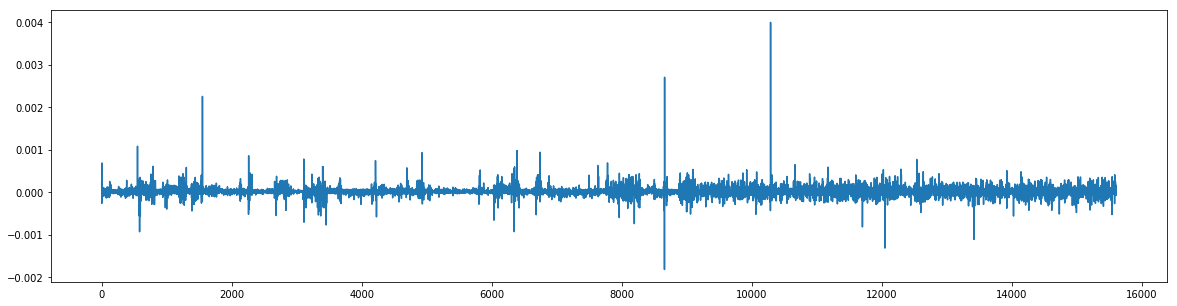

In [82]:
fig,ax=plt.subplots(figsize=(20,5))

ax.plot(W.fillna(0).mean().values)

In [88]:
tf.reset_default_graph()

In [89]:
sess.close()

In [90]:
from deepexplain.tensorflow import DeepExplain
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count={ "CPU": 44}))


In [91]:
saver.restore(sess, "/work/breastcancer/clean_test/logs/preprocessed001.ckpt")
r=sess.run(tf.nn.sigmoid(output),feed_dict={X:x_val,Y:y_val})

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [37]:
r

NameError: name 'r' is not defined

In [51]:
with DeepExplain(session=sess) as de:  # < enter DeepExplain context
    #tf.reset_default_graph()
    #tf.reset_default_graph()
    X=tf.placeholder(tf.float32,shape=(None,5273),name="X")
    X_random=tf.placeholder(tf.float32,shape=(None,1),name="X")
    Y=tf.placeholder(tf.float32,shape=(None,1),name="Y")
    training = tf.placeholder_with_default(False, shape=(), name='training')
    initializer = tf.contrib.layers.xavier_initializer()
    hidden00_drop= tf.layers.dropout(X, 0.5, training=training)
    hidden01=tf.layers.dense(hidden00_drop, 1000, name="hidden01",activation=None, kernel_initializer=initializer)
    hidden01_norm=tf.layers.batch_normalization(hidden01, training=training, momentum=0.9)
    act_hidden01=tf.nn.leaky_relu(hidden01_norm)
    hidden01_drop = tf.layers.dropout(act_hidden01, 0.5, training=training)
    hidden0=tf.layers.dense(hidden01_drop, 250, name="hidden0",activation=None, kernel_initializer=initializer)
    hidden0_norm=tf.layers.batch_normalization(hidden0, training=training, momentum=0.9)
    act_hidden0=tf.nn.leaky_relu(hidden0_norm)
    hidden0_drop = tf.layers.dropout(act_hidden0, 0.5, training=training)
    hidden1=tf.layers.dense(hidden0_drop, 50, name="hidden1",activation=None, kernel_initializer=initializer)
    hidden1_norm=tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
    act_hidden1=tf.nn.leaky_relu(hidden1_norm)
    hidden1_drop = tf.layers.dropout(act_hidden1, 0.5, training=training)
    output=tf.layers.dense(  hidden1_drop, 1, name="output_final",activation=None)
    saver=tf.train.Saver()
    saver.restore(sess, "/work/breastcancer/clean_test/logs/preprocessed001.ckpt")
    a=de.explain('deeplift', output*y_val[important], X, x_val[important])

W1120 13:48:10.414178 47675134122304 deprecation_wrapper.py:118] From /work/omicsbio/adbadre/src/deepexplain/deepexplain/tensorflow/methods.py:635: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1120 13:48:10.416981 47675134122304 deprecation_wrapper.py:118] From /work/omicsbio/adbadre/src/deepexplain/deepexplain/tensorflow/methods.py:76: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/work/omicsbio/adbadre/src/deepexplain/deepexplain/tensorflow/methods.py:611: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


In [52]:
bim[bim["snp"]=="chr10_123467015_C_G"]

,chrom,snp,cm,pos,a0,a1,i
3431,10,chr10_123467015_C_G,0.0,123467015,G,C,3431


In [53]:
mean_snp=[]
aa=np.mean(np.array(a),axis=0)

#not_good=np.argwhere(aa<10**-4)
#good=np.argwhere(aa>10**-2)
#aa[aa>10**-4].shape

In [92]:
pf=pd.read_csv("/work/breastcancer/clean_test/train/logistic_filter_0_001.assoc.logistic",sep="\s+")[["SNP","P"]].sort_values(by=["P"]).reset_index(drop=True)
p_value=pd.read_csv("/work/breastcancer/clean_test/train/logistic_filter_0_001.assoc.logistic",sep="\s+")[["SNP","P"]]["SNP"].values

In [93]:
lime_logistic=[]
for i in important_lime2:
    lime_logistic.append(pf[pf["SNP"].str.contains(i)].values[0])

In [94]:
pf#.sort_values(by=["P"])

,SNP,P
0,rs62489409,2.178000e-59
1,rs2981584,1.369000e-49
2,rs2912774,2.918000e-49
3,rs2936870,6.122000e-49
4,rs2981575,3.757000e-48
5,rs1219651,4.433000e-48
6,rs1219642,1.455000e-47
7,rs2912780,1.572000e-47
8,rs1219648,2.104000e-47
9,rs2981579,2.305000e-47


In [95]:
important_lime

array(['rs12542492=2', 'chr8_89514784_A_G=2', 'chr16_52328666_C_T=2',
       'chr10_123467015_C_G=0', 'chr5_111413372_G_T=2',
       'chr5_26657987_A_G=2', 'chr2_8196361_A_C=2', 'chr16_8755147_C_T=2',
       'chr19_56005289_C_T=0', 'rs3858522=2', 'chr2_168306484_C_T=2',
       'chr6_117598048_A_G=2', 'Chr6:30954121:G:T=2', 'rs132392=0',
       'chr5_56324570_C_G=2', 'chr11_1937696_C_T=2',
       'chr1_97788840_A_G=0', 'chr4_73793618_C_T=2',
       'chr20_11343864_C_T=2', 'rs1737035=2', 'chr14_101121371_G_T=2',
       'chr2_217957699_G_T=2', 'chr4_53438173_A_G=2', 'rs34839759=2',
       'exm414370=2', 'rs28637953=0', 'rs11642757=2',
       'chr3_46742523_A_C=2', 'rs68018508=2', 'rs425335=2', 'rs7025424=2',
       'rs11869626=2', 'chr17_2990014_G_T=2', 'corect_rs139337779=2',
       'chr9_16917672_G_T=2', 'rs1150850=2', 'chr6_32486299_C_T=2',
       'rs4040605=2', 'chr13_113796587_A_G=2', 'rs4714648=2',
       'chr4_28134269_A_C=2', 'chr8_130380476_C_T=2', 'rs1500206=2',
       'chr11_11

In [96]:
np.array(lime_logistic)

array([['rs12542492', 6.305e-11],
       ['chr8_89514784_A_G', 2.483e-05],
       ['chr16_52328666_C_T', 1.5079999999999998e-41],
       ...,
       ['chr3_46894988_A_C', 0.0006642],
       ['rs12940064', 0.0007673],
       ['rs8015790', 0.0004921]], dtype=object)

In [97]:
imp=pd.DataFrame(lime_logistic)[:1000]

In [98]:
imp.columns=["SNP","P"]

In [99]:
imp.to_csv("/work/breastcancer/clean_test/results/top1000_important_lime2.csv")

In [351]:
imp

,SNP,P
0,rs34923393,5.043000e-15
1,rs10792009,5.465000e-05
2,chr13_113284191_C_T,7.779000e-23
3,rs6118063,7.790000e-10
4,chr21_20106580_A_G,2.079000e-10
5,chr12_15177511_C_T,4.214000e-10
6,chr2_150721127_A_C,4.395000e-15
7,chr2_23222481_C_T,2.026000e-24
8,chr2_171708059_C_T,1.900000e-11
9,chr3_71305759_A_G,1.003000e-04


In [80]:
positions=[]
for i in important_lime2:
    positions.append(bim[bim["snp"].str.contains(i)].index.values[0])

Text(0.5,1,'SNPs Importance using DeepLift')

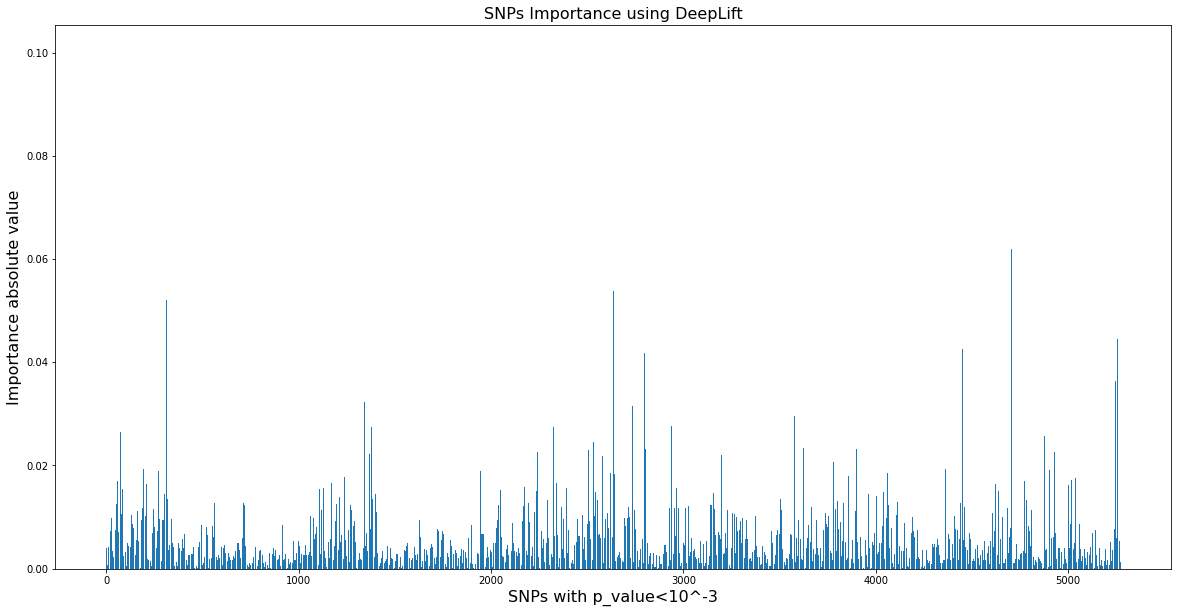

In [145]:
fig,ax=plt.subplots(figsize=(20,10))
ax.bar([x for x  in range(aa.shape[0])],np.absolute(aa))
ax.set_xlabel("SNPs with p_value<10^-3",fontsize=16)
ax.set_ylabel("Importance absolute value",fontsize=16)
plt.title("SNPs Importance using DeepLift",fontsize=16)

In [135]:
aa[positions][np.absolute(aa[positions])>0.04442].shape

(5,)

In [136]:
aa[np.absolute(aa)>0.04442].shape

(25,)

In [146]:
bim

,chrom,snp,cm,pos,a0,a1,i
0,1,rs4040605,0.0,856476,G,A,0
1,1,chr1_1914124_C_T,0.0,1914124,A,G,1
2,1,chr1_2501064_A_G,0.0,2501064,A,G,2
3,1,chr1_3410935_A_G,0.0,3410935,A,G,3
4,1,chr1_4515277_C_T,0.0,4515277,A,G,4
5,1,chr1_5178521_A_C,0.0,5178521,C,A,5
6,1,rs2506889,0.0,10596022,A,G,6
7,1,chr1_10598216_A_G,0.0,10598216,A,G,7
8,1,chr1_10609973_G_T,0.0,10609973,A,C,8
9,1,rs9430149,0.0,10612820,C,G,9


(23,)

In [140]:
concordance=[]
for i in range(100):
    concordance.append(aa[positions][np.absolute(aa[positions])>i*0.001].shape[0]/aa[np.absolute(aa)>i*0.001].shape[0])

In [141]:
np.savetxt("/work/breastcancer/clean_test/results/corcordance.csv",np.array(concordance))

In [142]:
np.max(np.absolute(aa))

0.100322604

Text(0.5,1,'Concordance Rate between Deep Lift and Lime')

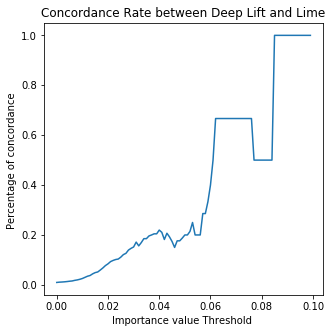

In [143]:
fig,ax=plt.subplots(figsize=(5,5))
ax.plot([i*0.001 for i in range(100)],concordance)
ax.set_ylabel("Percentage of concordance ")
ax.set_xlabel("Importance value Threshold ")
plt.title("Concordance Rate between Deep Lift and Lime")

In [89]:
bim[bim["snp"].str.contains("rs10064567")]

,chrom,snp,cm,pos,a0,a1,i
1385,5,rs10064567,0.0,37796430,G,A,1385


In [ ]:
['chr11_111757486_A_G=1', 'chr1_97788840_A_G=1', 'chr2_171708059_C_T=1',
       'chr2_28150862_A_C=1', 'chr4_169989297_G_T=1', 'corect_rs187434740=0',
       'rs10064567=0']

In [90]:
aa[1385]

-0.016462512

In [278]:
len(np.intersect1d(np.array(not_sig),not_good))

2667

In [279]:
good.shape

(446, 1)

In [280]:
len(sig_val)

69

In [281]:
len(np.intersect1d(np.array(sig_val),good))

2

[<matplotlib.lines.Line2D at 0x2b747ffca208>]

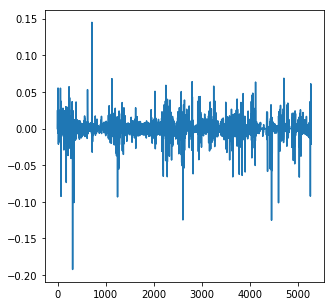

In [255]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(a[4])

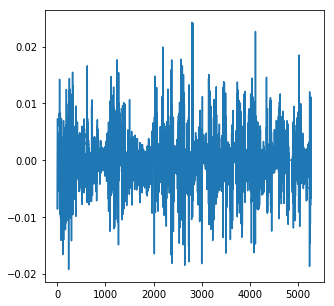

In [38]:
afig, ax = plt.subplots(figsize=(5,5))
ax.plot(a[3839])

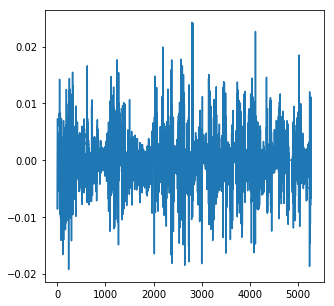

In [19]:
afig, ax = plt.subplots(figsize=(5,5))
ax.plot(a[3839])

In [118]:
import shap

In [158]:
e=shap.DeepExplainer((X,tf.nn.sigmoid(output)), x_train[np.random.choice(x_train.shape[0], 1000, replace=False)])

In [159]:
x_test

array([[2, 2, 2, ..., 1, 2, 2],
       [1, 2, 0, ..., 1, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 1, ..., 1, 2, 2],
       [2, 2, 2, ..., 0, 2, 2],
       [1, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [160]:
e.shap_values(x_val[important])

ValueError: Dimensions must be equal, but are 50 and 25 for 'gradients/batch_normalization_2/batchnorm/mul_1_grad/mul' (op: 'Mul') with input shapes: [?,50], [25].